# 04 Chain-of-Thoughts y Comparativa de Inferencia

❤️ Creado por [@Edison_Bejarano](https://github.com/EjbejaranosAI/llm-hub/blob/main/mastery/notebooks/).

**Objetivo:** mostrar cómo un LLM resuelve problemas con inferencia directa versus razonamiento paso a paso (Chain-of-Thought), incluyendo métricas de tiempo y tokens generados.

**Prerequisitos:** Python 3.11+, GPU opcional, drivers/CUDA si aplica.

**Índice del Notebook:**
1. Instalación de dependencias (`optillm`, `transformers`, `matplotlib`, `pandas`)
2. Carga del modelo instructivo y tokenizer
3. Preparación de problemas de ejemplo
4. Funciones de benchmark para medir tiempo y tokens
5. Ejecución de inferencia normal vs Chain-of-Thought
6. Comparativa gráfica (tiempo y tokens generados)
7. Resultados detallados y discusión
8. Conclusiones y aprendizajes para estudiantes


## 1. Instalación de dependencias

In [3]:
%%capture
!pip uninstall -y pandas numpy
!pip install -q numpy==1.25.0
!pip install -q transformers==4.40.0 optillm
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q pandas

## 2. Imports y carga del modelo

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from optillm.cot_decoding import cot_decode
from optillm.entropy_decoding import entropy_decode
import torch
import time
import matplotlib.pyplot as plt


# Modelo instructivo para la demo
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

# Cargar modelo y tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
!pip uninstall -y numpy pandas
!pip install --no-cache-dir numpy==1.26.4 pandas==2.3.2

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.3.2
Uninstalling pandas-2.3.2:
  Successfully uninstalled pandas-2.3.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 252.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 197.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 109.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is inco

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [1]:
import pandas

## 3. Preparar problemas de prueba

In [2]:
# Lista de problemas matemáticos/lógicos
problems = [
    {"role": "user", "content": "In a dance class of 20 students, 20% enrolled in contemporary dance, 25% of the remaining enrolled in jazz dance, and the rest enrolled in hip-hop dance. What percentage of the entire students enrolled in hip-hop dance?"},
    {"role": "user", "content": "A farmer has 10 cows and buys 5 more. If he sells 6, how many cows does he have now?"},
    {"role": "user", "content": "If a train travels 60 miles in 1 hour and 30 minutes, what is its average speed in miles per hour?"}
]

In [3]:
problems

[{'role': 'user',
  'content': 'In a dance class of 20 students, 20% enrolled in contemporary dance, 25% of the remaining enrolled in jazz dance, and the rest enrolled in hip-hop dance. What percentage of the entire students enrolled in hip-hop dance?'},
 {'role': 'user',
  'content': 'A farmer has 10 cows and buys 5 more. If he sells 6, how many cows does he have now?'},
 {'role': 'user',
  'content': 'If a train travels 60 miles in 1 hour and 30 minutes, what is its average speed in miles per hour?'}]

## 4. Funciones auxiliares para medición


In [5]:
def benchmark_inference(model, tokenizer, messages, use_cot=False, max_new_tokens=128):
    """
    Ejecuta inferencia normal o CoT y mide tiempo y tokens generados.
    """
    start = time.perf_counter()
    if use_cot:
        result, _ = cot_decode(model, tokenizer, messages, aggregate_paths=True, max_new_tokens=max_new_tokens)
    else:
        result = entropy_decode(model, tokenizer, messages, max_new_tokens=max_new_tokens)
    end = time.perf_counter()

    # Contar tokens generados
    inputs = tokenizer([m["content"] for m in messages], return_tensors="pt", padding=True)
    output_tokens = tokenizer(result, return_tensors="pt")["input_ids"].shape[1]

    return {
        "result": result,
        "time_sec": end - start,
        "tokens": output_tokens
    }


## 5. Ejecutar benchmark en todos los problemas

In [6]:
data = []

for i, prob in enumerate(problems):
    # Inferencia normal
    normal = benchmark_inference(model, tokenizer, [prob], use_cot=False)
    # Chain-of-Thought
    cot = benchmark_inference(model, tokenizer, [prob], use_cot=True)

    data.append({
        "problem": f"Problem {i+1}",
        "normal_result": normal["result"],
        "normal_time": normal["time_sec"],
        "normal_tokens": normal["tokens"],
        "cot_result": cot["result"],
        "cot_time": cot["time_sec"],
        "cot_tokens": cot["tokens"]
    })



Qwen2Model is using Qwen2SdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [9]:
import pandas as pd
df = pd.DataFrame(data)
df

,problem,normal_result,normal_time,normal_tokens,cot_result,cot_time,cot_tokens
0,Problem 1,There are 20 students enrolled in total in the...,8.329646,128,To determine the percentage of the entire stud...,39.520447,129
1,Problem 2,To determine how many cows the farmer has afte...,4.204498,128,"Sure, let's break it down step by step:\n\n1. ...",26.160315,109
2,Problem 3,"To calculate the average speed of the train, w...",4.904929,128,Average speed is calculated by dividing the to...,36.098176,129


## 6. Comparativa gráfica

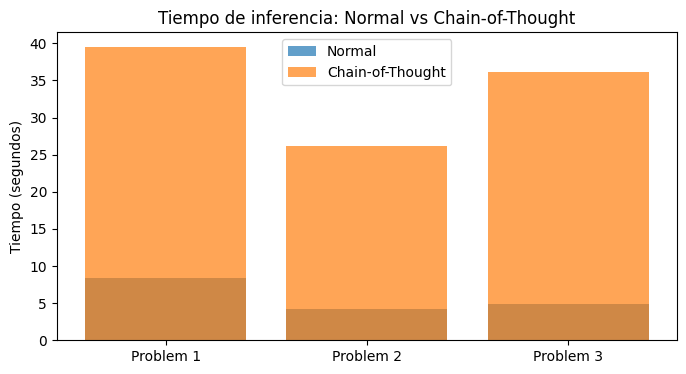

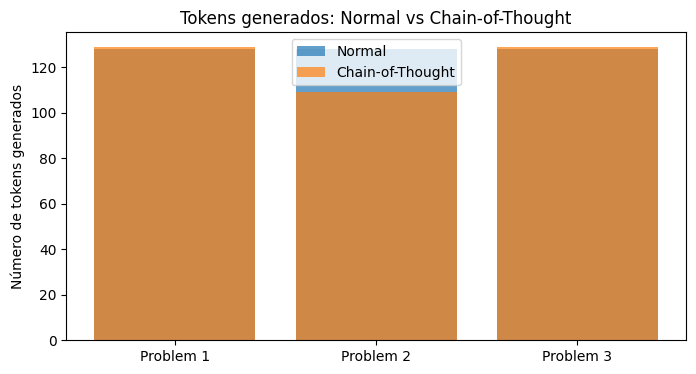

In [10]:
# Gráficas de tiempo
plt.figure(figsize=(8,4))
plt.bar(df["problem"], df["normal_time"], label="Normal", alpha=0.7)
plt.bar(df["problem"], df["cot_time"], label="Chain-of-Thought", alpha=0.7)
plt.ylabel("Tiempo (segundos)")
plt.title("Tiempo de inferencia: Normal vs Chain-of-Thought")
plt.legend()
plt.show()

# Gráficas de tokens generados
plt.figure(figsize=(8,4))
plt.bar(df["problem"], df["normal_tokens"], label="Normal", alpha=0.7)
plt.bar(df["problem"], df["cot_tokens"], label="Chain-of-Thought", alpha=0.7)
plt.ylabel("Número de tokens generados")
plt.title("Tokens generados: Normal vs Chain-of-Thought")
plt.legend()
plt.show()


## 7. Mostrar resultados completos

In [11]:
for i, row in df.iterrows():
    print(f"--- {row['problem']} ---")
    print("Inferencia normal:")
    print(row['normal_result'])
    print("\nChain-of-Thought:")
    print(row['cot_result'])
    print(f"\nTiempo normal: {row['normal_time']:.2f}s | CoT: {row['cot_time']:.2f}s")
    print(f"Tokens normal: {row['normal_tokens']} | Tokens CoT: {row['cot_tokens']}")
    print("\n" + "="*60 + "\n")


--- Problem 1 ---
Inferencia normal:
There are 20 students enrolled in total in the dance class. We start by calculating the number of students enrolled in contemporary dance:

1. Current numbers in current and other dances:
   - Students in other types: \( 20 - 20\% \times 20 = 20 - 4 = 16 \)
   - Total students enrolled: 20

Since 20 is twice that number and there are twice as many girls instead of boys, there are:

2. Subtract half: \( 20 - 16 = 4 \) girls
3. Subtract the

Chain-of-Thought:
To determine the percentage of the entire students enrolled in hip-hop dance, we first need to calculate the number of students enrolled in each of the other two dance styles.

1. Calculate the number of students enrolled in contemporary dance:
   \[
   \text{Number of students in contemporary dance} = 20\% \times 20 = 0.20 \times 20 = 4
   \]

2. Calculate the number of students remaining after subtracting those enrolled in contemporary dance:
   \[
   \text{Number of students remaining} = 20 - 